In [1]:
# basemodels
from models import QuantileLinearRegressor, QuantileForestRegressor, QuantileNeuralRegressor
from neuralprophet import NeuralProphet
from arima import ARIMA

# metrics for comparison
from metrics import Metrics

# conformal methods to use
from conformal_methods import ACI, CQR, EnbPI, EnCQR

# data generation and subplots
from utils import SyntheticData, create_subplots, \
train_val_test, split_x_y, compute_aci, optimize_conformal, plot_test_PIs

# data science
import pandas as pd
import numpy as np
from sktime.utils.plotting import plot_series
from sktime.utils import plotting
from tqdm import tqdm
import matplotlib.pyplot as plt

import quantnn
import run_experiment


import torch
import random
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

## Data

In [2]:
dataset = "google"

In [3]:
df, df_train, df_val, df_test, T, tvt_split = run_experiment.get_data(dataset)

In [4]:
quantiles: dict = {"lower": 0.05, "middle": 0.5, "upper" : 0.95}

In [5]:
# 90, 80, 70, 60, 50 % prediction intervals
lower_quantiles = [0.05, 0.1, 0.15, 0.2, 0.25]
upper_quantiles = [0.95, 0.9, 0.85, 0.8, 0.75]

## The idea is
We predict using multi step forecasting and use different numbers

In [6]:
# We get a plot with on the x-axis different quantile estimates
# and on the y-axis the PIAW metric, but we also compute PICP

In [7]:
def predict_linear(quantiles: dict):
    QLR_predictions = {}
        
    # fit each prompted quantile and predict on all samples

    QLR = QuantileLinearRegressor(quantiles=list(quantiles.values()))
    QLR.fit(df_train["y_lag"].to_numpy().reshape(-1,1), 
            df_train["y"].to_numpy())

    y_pred = QLR.predict(df["y_lag"].to_numpy().reshape(-1,1))
    print(y_pred.shape)

    QLR_predictions["lower"] = y_pred[:, 0].reshape(1,-1,1)
    QLR_predictions["middle"] = y_pred[:, 1].reshape(1,-1,1)
    QLR_predictions["upper"] = y_pred[:, 2].reshape(1,-1,1)
    
    return QLR_predictions

def predict_forest(quantiles: dict):
    X_all, y_all = df["y_diff_lag"].to_numpy().reshape(-1,1), df["y_diff"].to_numpy()
    X_train, y_train = df_train["y_diff_lag"].to_numpy().reshape(-1,1), df_train["y_diff"].to_numpy()
    X_val, y_val = df_val["y_diff_lag"].to_numpy().reshape(-1,1), df_val["y_diff"].to_numpy()
    X_test, y_test = df_test["y_diff_lag"].to_numpy().reshape(-1,1), df_test["y_diff"].to_numpy()
    
    QFR_predictions = {}
    
    QFR = QuantileForestRegressor(y_real=df["y"].to_numpy(), quantiles=list(quantiles.values()), max_depth=2, differencing=False)
    QFR.fit(X_train, y_train)
    
    y_pred = QFR.predict(X_all)
    
    QFR_predictions["lower"] = y_pred[:, 0].reshape(1, -1, 1)
    QFR_predictions["middle"] = y_pred[:, 1].reshape(1, -1, 1)
    QFR_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)
    
    return QFR_predictions

def predict_neuralnet(quantiles: dict):
    layers = 4
    neurons = 256
    activation = "relu"
    model = (layers, neurons, activation)
    qrnn = QuantileNeuralRegressor(quantiles=list(quantiles.values()), n_inputs=1, model_params=model)
    
    logs = qrnn.fit(df_train["y_lag"].to_numpy().reshape(-1,1), df_train["y"].to_numpy(), n_epochs=15)
    
    y_pred = qrnn.predict(df["y_lag"].values.reshape(-1,1))

    NN_predictions = {}
    NN_predictions["lower"] = y_pred[:,0].reshape(1, -1, 1)
    NN_predictions["middle"] = y_pred[:,1].reshape(1, -1, 1)
    NN_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)
    
    return NN_predictions


In [8]:
def create_step_predictions(df, df_train, df_val, df_test, model, stepsize=4):
    # concatentate test and validation data
    df_val_test = pd.concat([df_val, df_test])
    test_lags = df_val_test["y_lag"].to_numpy().reshape(-1,1)

    # first we predict on train and validation data
    y_pred_train = model.predict(df_train["y_lag"].to_numpy().reshape(-1,1))
#     y_pred_val = model.predict(df_val["y_lag"].to_numpy().reshape(-1,1))

    y_pred_test = np.zeros((len(test_lags), len(quantiles)))
    # then we predict on test data
    
    
    for i in range(0, len(test_lags), stepsize):
            # print("i: ", i)
        # we take steps of 5

            # create regular lag prediction
            y_pred_t = model.predict(test_lags[i, 0].reshape(-1,1))
            y_pred_test[i, : ] = y_pred_t
            
            # only do other sequential lags if it fits in the data
            if i < len(test_lags) - 1:
                test_lags[i+1] = y_pred_t[0][1]
                
                # let's say 1207 samples, then if i=1200, we still want to predict 6 steps -> (1,7)
                steps = np.min([stepsize, (len(test_lags) - i)])
                    
                #  sequential predictions or what's left
                for j in range(1, steps):
                    y_pred_t = model.predict(test_lags[i+j, 0].reshape(-1,1))
                    y_pred_test[i+j, :] = y_pred_t
                    
                    # the last sequential prediction shouldnt change lags because the next should be true
                    if j < steps-1:
                        test_lags[i+j+1] = y_pred_t[0][1]
                        
            if steps != stepsize:
                break
            
    y_pred = np.concatenate([y_pred_train, y_pred_test], axis=0)
    return y_pred

In [9]:
def predict_linear_step(stepsize=4):
    
    QLR_predictions = {}
        
    # fit each prompted quantile and predict on all samples

    QLR = QuantileLinearRegressor(quantiles=quantiles.values())
    QLR.fit(df_train["y_lag"].to_numpy().reshape(-1,1), 
            df_train["y"].to_numpy())
    y_pred = create_step_predictions(df, df_train, df_val, df_test, model=QLR, stepsize=stepsize)
    print(y_pred)

    QLR_predictions["lower"] = y_pred[:, 0].reshape(1,-1,1)
    QLR_predictions["middle"] = y_pred[:, 1].reshape(1,-1,1)
    QLR_predictions["upper"] = y_pred[:, 2].reshape(1,-1,1)
    
    return QLR_predictions

In [10]:
def predict_neural_step(stepsize=4):
    layers = 4
    neurons = 256
    activation = "relu"
    model = (layers, neurons, activation)
    qrnn = QuantileNeuralRegressor(quantiles=list(quantiles.values()), n_inputs=1, model_params=model)
    
    logs = qrnn.fit(df_train["y_lag"].to_numpy().reshape(-1,1), df_train["y"].to_numpy(), n_epochs=15)
    
    
    y_pred = create_step_predictions(df, df_train, df_val, df_test, model=qrnn, stepsize=stepsize)

    NN_predictions = {}
    NN_predictions["lower"] = y_pred[:,0].reshape(1, -1, 1)
    NN_predictions["middle"] = y_pred[:,1].reshape(1, -1, 1)
    NN_predictions["upper"] = y_pred[:,2].reshape(1, -1, 1)
    
    return NN_predictions


In [11]:
def cqr_predict(predictions, df, df_val, df_test, tvt_split):
    qcr = CQR()
    conformal_intervals = qcr.create_conformal_interval(predictions, df_test["y"].to_numpy(), 
                                                        df_val["y"].to_numpy(), T,
                                                        tvt_split=tvt_split)
    
    plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= predictions["middle"][0][df_test["t"],0],
               PI_low = predictions["lower"][0][df_test["t"],0], PI_hi = predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='CQR')
    
    metric = Metrics(df_test["y"].to_numpy(), predictions["middle"][0][df_test["t"].to_numpy(), 0], conformal_intervals[:,0], conformal_intervals[:,1],)


    return metric.computeAll(model_name="NN CQR").values()

def aci_predict(predictions, df, df_val, df_test, tvt_split):
    aci = ACI()
    conformal_intervals = aci.create_conformal_interval(predictions, df_test["y"].to_numpy(), 
                                                        df_val["y"].to_numpy(), T,
                                                        tvt_split=tvt_split)
    
    plot_test_PIs(true=df_test["y"].to_numpy(),pred_mean= predictions["middle"][0][df_test["t"],0],
               PI_low = predictions["lower"][0][df_test["t"],0], PI_hi = predictions["upper"][0][df_test["t"],0],
               conf_PI_low=conformal_intervals[:,0], conf_PI_hi=conformal_intervals[:,1],
               x_label="time", y_label="y", title='ACI')
    
    plt.show()
    
    metric = Metrics(df_test["y"].to_numpy(), predictions["middle"][0][df_test["t"].to_numpy(), 0], conformal_intervals[:,0], conformal_intervals[:,1],)


    return metric.computeAll(model_name="NN ACI").values()
    
    

In [12]:
print(len(df_val) + len(df_test))

1207


In [13]:
np.arange(3,18,3)

array([ 3,  6,  9, 12, 15])

stepsize:  3


[[ 215.93349503  223.01746035  231.41286116]
 [ 218.87487024  226.02098665  234.36374424]
 [ 225.92048993  233.21547988  241.4321386 ]
 ...
 [1041.06047948 1065.57933062 1059.2070329 ]
 [1039.45926827 1063.94428591 1057.60064584]
 [1030.04947611 1054.33566538 1048.16043693]]


Output()

                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        86.071        
      2   0.0005        14.896        
      3   0.0005         7.400        
      4   0.0005         3.968        
      5   0.0005         1.731        
      6   0.0005         1.107        
      7   0.0005         1.042        
      8   0.0005         1.030        
      9   0.0005         1.020        
     10   0.0005         1.050        
     11   0.0005         1.039        
     12   0.0005         0.996        
     13   0.0005         1.004        
     14   0.0005         1.204        
     15   0.0005         1.211

[17:29:23] WARNING  No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun  ]8;id=499748;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py\xla_bridge.py]8;;\:]8;id=375441;file:///home/dirk/thesis/lib/python3.10/site-packages/jax/_src/xla_bridge.py#448\448]8;;\
                    for more info.)                                                                                

100%|██████████| 604/604 [01:03<00:00,  9.49it/s]


<Figure size 640x480 with 0 Axes>

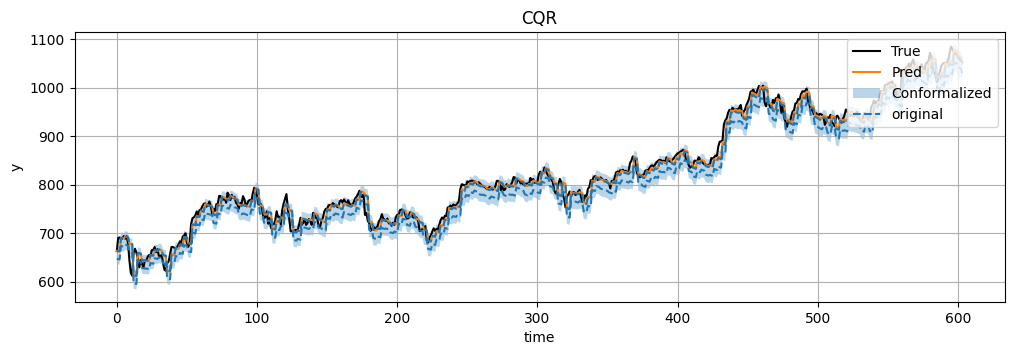

<Figure size 640x480 with 0 Axes>

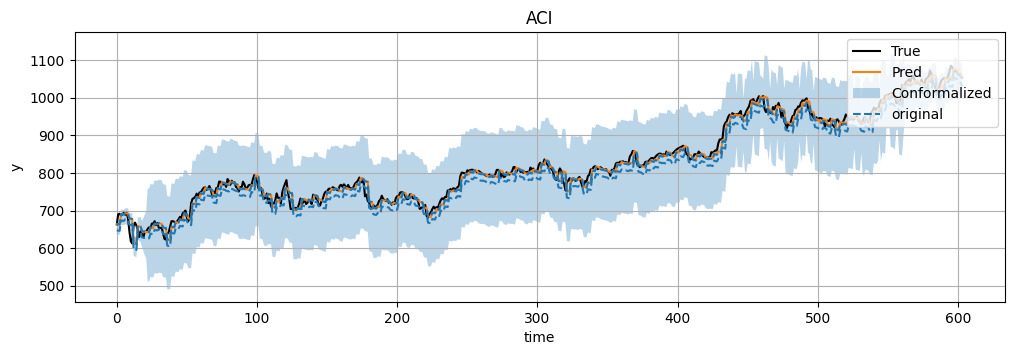

100%|██████████| 604/604 [00:00<00:00, 656.76it/s]


<Figure size 640x480 with 0 Axes>

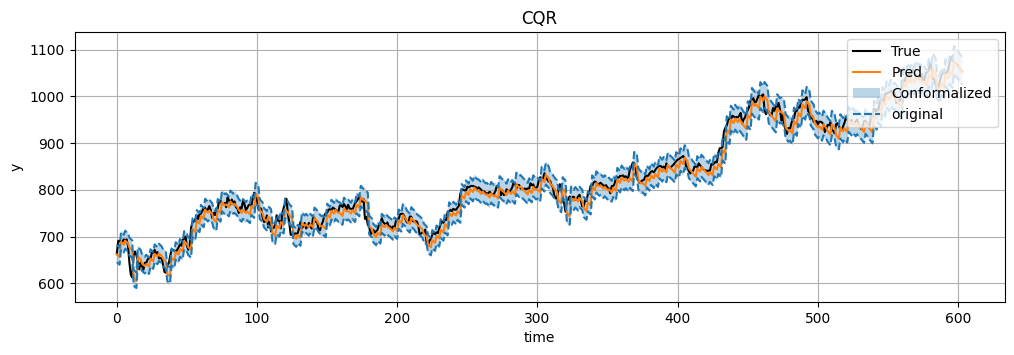

<Figure size 640x480 with 0 Axes>

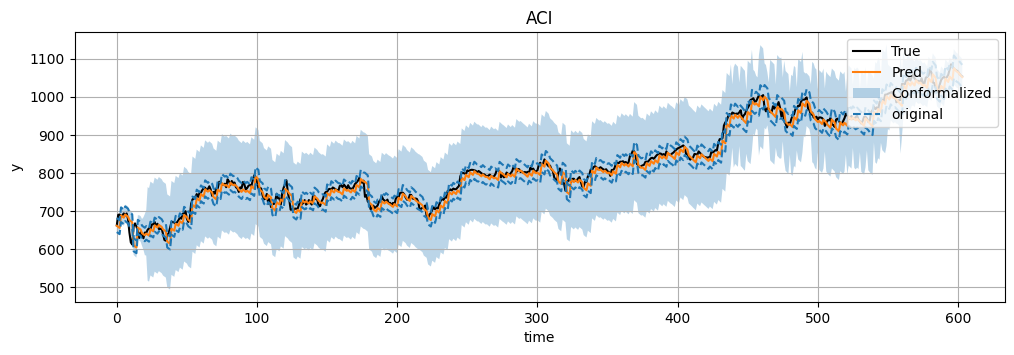

stepsize:  6


Output()

[[ 215.93349503  223.01746035  231.41286116]
 [ 218.87487024  226.02098665  234.36374424]
 [ 225.92048993  233.21547988  241.4321386 ]
 ...
 [1046.84669907 1071.4878127  1065.01195619]
 [1045.23304326 1069.84006044 1063.39308431]
 [1030.04947611 1054.33566538 1048.16043693]]


                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        85.800        
      2   0.0005        13.329        
      3   0.0005         8.323        
      4   0.0005         4.223        
      5   0.0005         1.674        
      6   0.0005         1.254        
      7   0.0005         1.070        
      8   0.0005         1.042        
      9   0.0005         1.051        
     10   0.0005         1.092        
     11   0.0005         1.055        
     12   0.0005         1.077        
     13   0.0005         1.126        
     14   0.0005         1.111        
     15   0.0005         1.056

100%|██████████| 604/604 [00:01<00:00, 571.42it/s]


<Figure size 640x480 with 0 Axes>

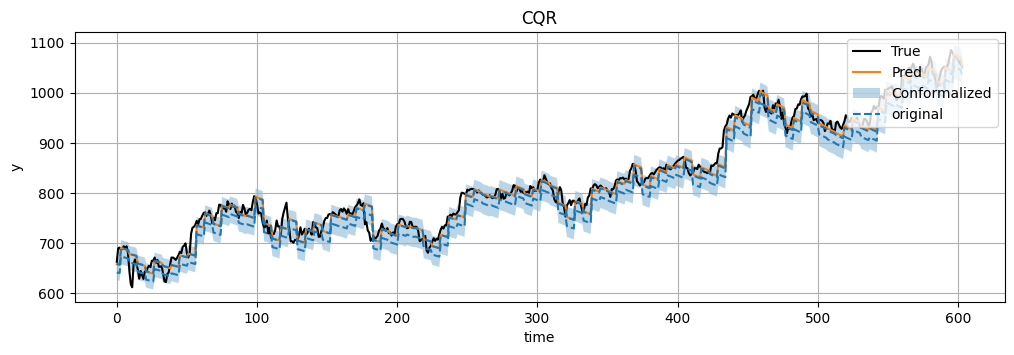

<Figure size 640x480 with 0 Axes>

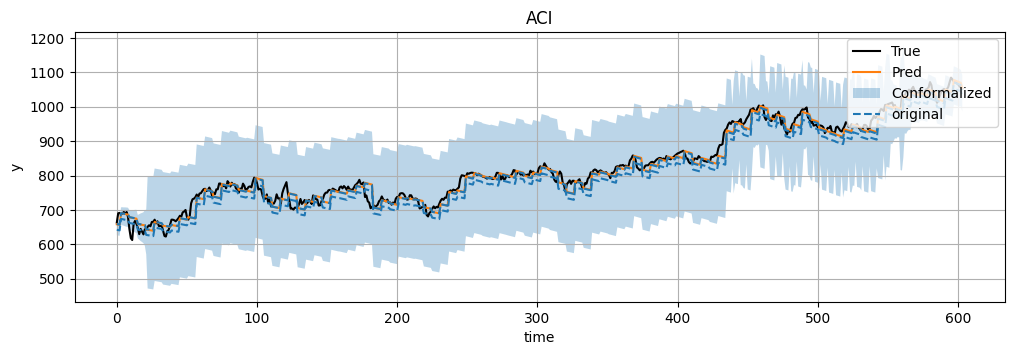

100%|██████████| 604/604 [00:01<00:00, 600.13it/s]


<Figure size 640x480 with 0 Axes>

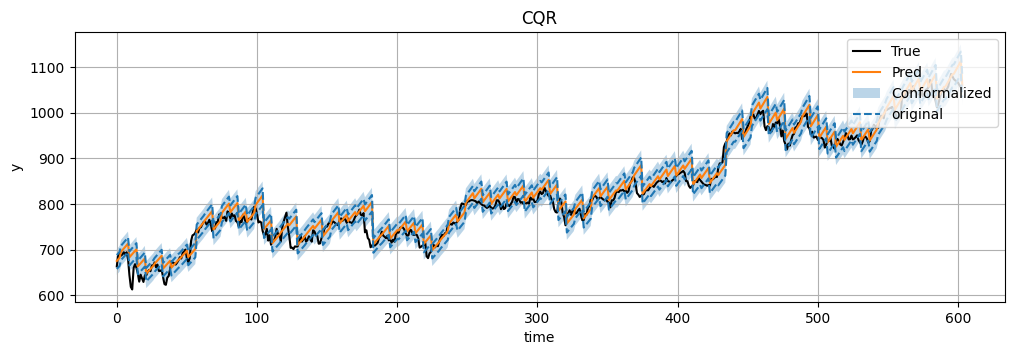

<Figure size 640x480 with 0 Axes>

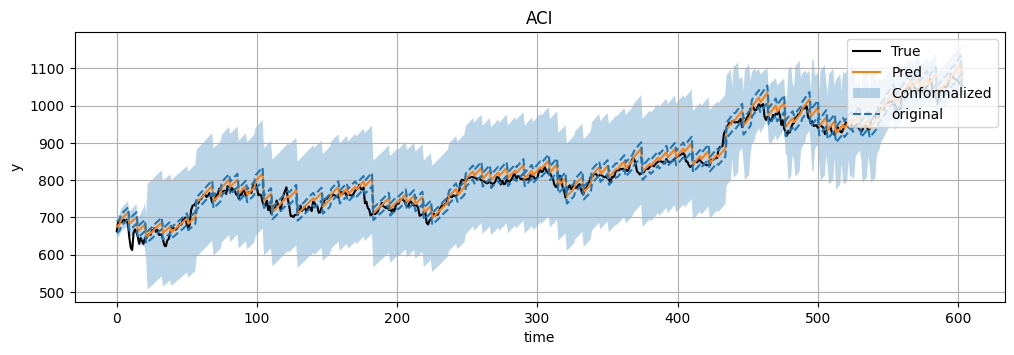

stepsize:  9


Output()

[[ 215.93349503  223.01746035  231.41286116]
 [ 218.87487024  226.02098665  234.36374424]
 [ 225.92048993  233.21547988  241.4321386 ]
 ...
 [1020.54089168 1044.62616511 1038.62111641]
 [1018.98381257 1043.03618501 1037.05900411]
 [1030.04947611 1054.33566538 1048.16043693]]


                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        73.745        
      2   0.0005        13.808        
      3   0.0005         6.375        
      4   0.0005         3.481        
      5   0.0005         2.107        
      6   0.0005         1.164        
      7   0.0005         1.033        
      8   0.0005         1.010        
      9   0.0005         0.996        
     10   0.0005         1.005        
     11   0.0005         1.091        
     12   0.0005         1.007        
     13   0.0005         1.030        
     14   0.0005         1.004        
     15   0.0005         1.028

100%|██████████| 604/604 [00:00<00:00, 643.60it/s]


<Figure size 640x480 with 0 Axes>

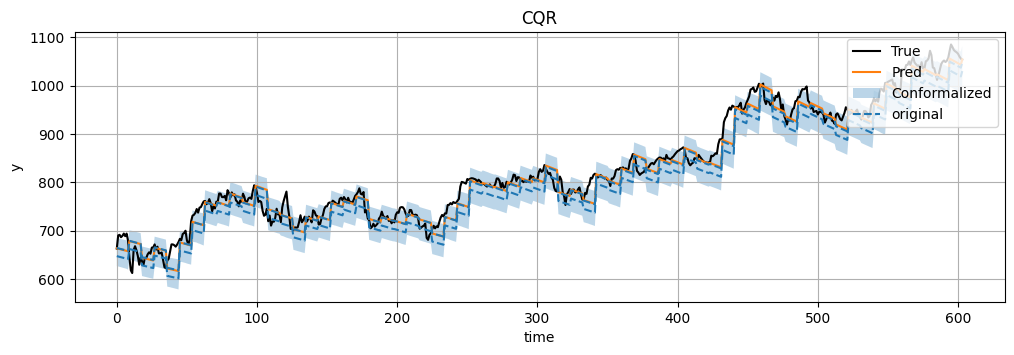

<Figure size 640x480 with 0 Axes>

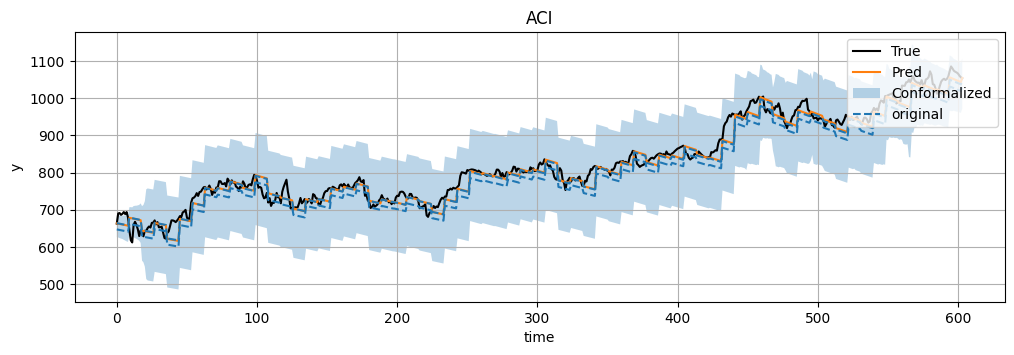

100%|██████████| 604/604 [00:00<00:00, 641.59it/s]


<Figure size 640x480 with 0 Axes>

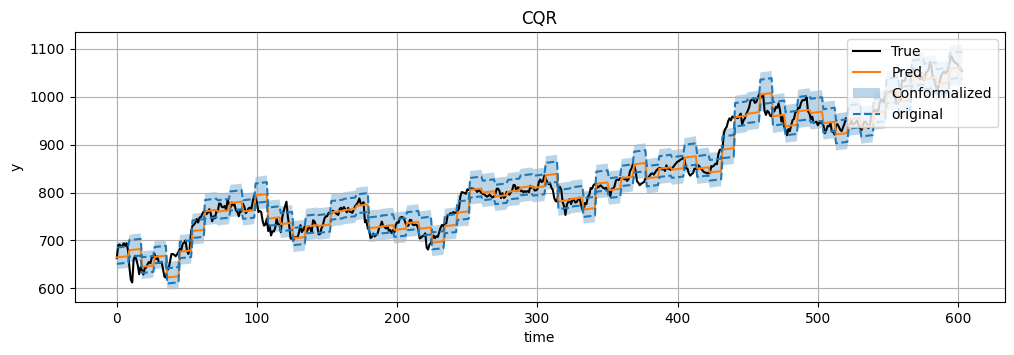

<Figure size 640x480 with 0 Axes>

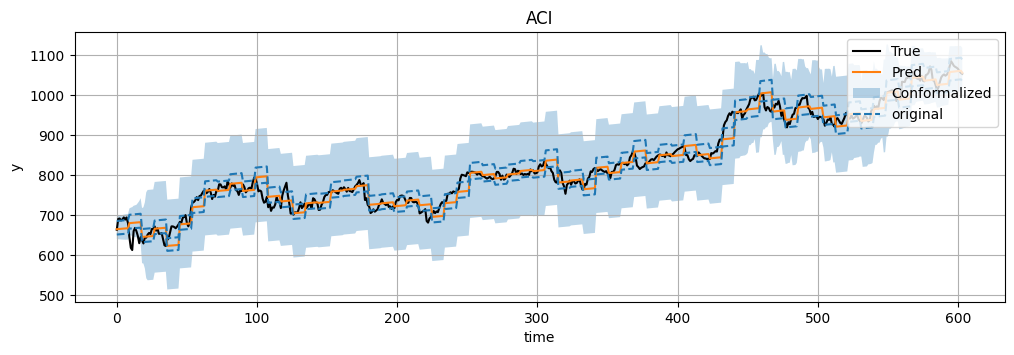

stepsize:  12


Output()

[[ 215.93349503  223.01746035  231.41286116]
 [ 218.87487024  226.02098665  234.36374424]
 [ 225.92048993  233.21547988  241.4321386 ]
 ...
 [1046.84669907 1071.4878127  1065.01195619]
 [1045.23304326 1069.84006044 1063.39308431]
 [1043.62285799 1068.19585205 1061.77769419]]


                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        77.088        
      2   0.0005        14.258        
      3   0.0005         7.578        
      4   0.0005         3.980        
      5   0.0005         1.766        
      6   0.0005         1.115        
      7   0.0005         1.055        
      8   0.0005         1.026        
      9   0.0005         0.990        
     10   0.0005         0.999        
     11   0.0005         1.056        
     12   0.0005         1.061        
     13   0.0005         1.006        
     14   0.0005         1.062        
     15   0.0005         1.072

100%|██████████| 604/604 [00:00<00:00, 657.00it/s]


<Figure size 640x480 with 0 Axes>

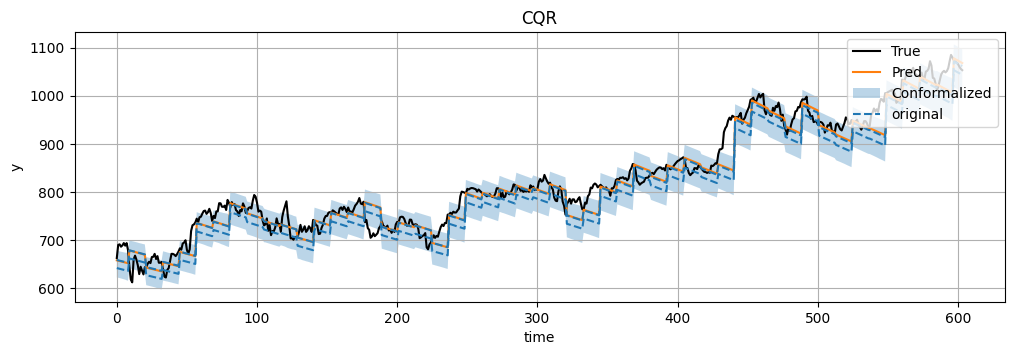

<Figure size 640x480 with 0 Axes>

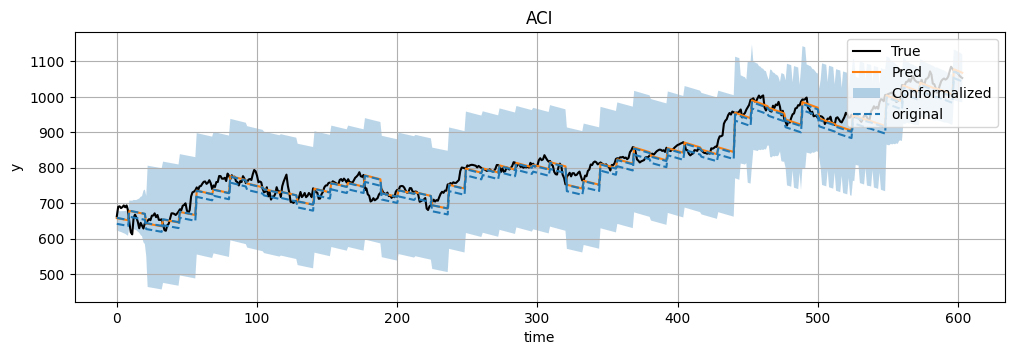

100%|██████████| 604/604 [00:01<00:00, 526.05it/s]


<Figure size 640x480 with 0 Axes>

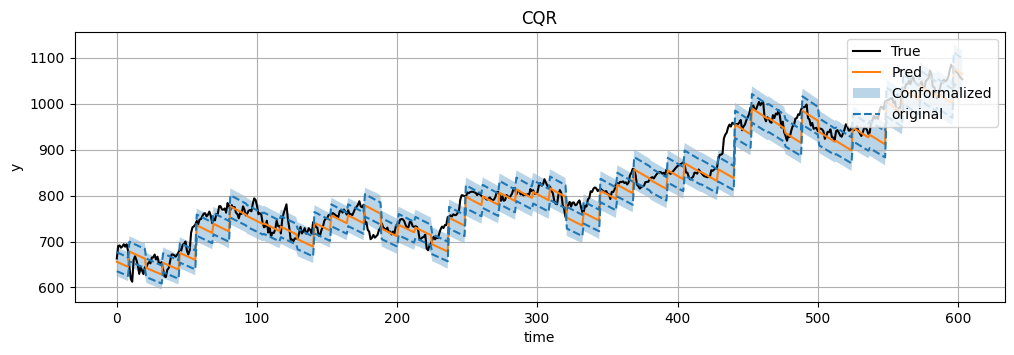

<Figure size 640x480 with 0 Axes>

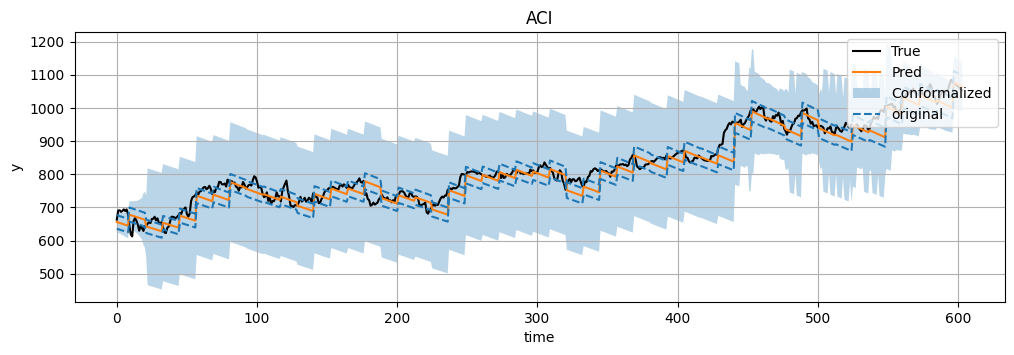

stepsize:  15


Output()

[[ 215.93349503  223.01746035  231.41286116]
 [ 218.87487024  226.02098665  234.36374424]
 [ 225.92048993  233.21547988  241.4321386 ]
 ...
 [1046.84669907 1071.4878127  1065.01195619]
 [1045.23304326 1069.84006044 1063.39308431]
 [1043.62285799 1068.19585205 1061.77769419]]


                                      
                                      
           Training history           
                                      
                                      
      Epoch          Training loss    
 ──────────────────────────────────── 
     #      LR           Total        
                                      
      1   0.0005        92.686        
      2   0.0005        16.155        
      3   0.0005         9.903        
      4   0.0005         4.923        
      5   0.0005         2.616        
      6   0.0005         1.408        
      7   0.0005         1.066        
      8   0.0005         1.016        
      9   0.0005         1.055        
     10   0.0005         1.024        
     11   0.0005         1.051        
     12   0.0005         1.026        
     13   0.0005         1.042        
     14   0.0005         1.034        
     15   0.0005         1.077

100%|██████████| 604/604 [00:00<00:00, 642.15it/s]


<Figure size 640x480 with 0 Axes>

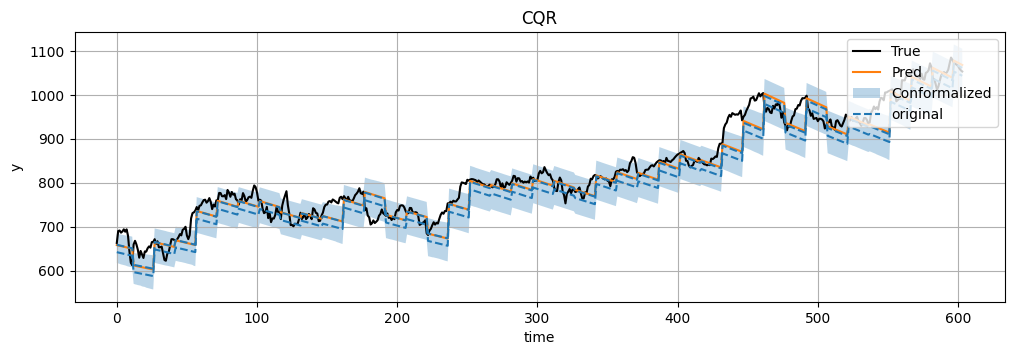

<Figure size 640x480 with 0 Axes>

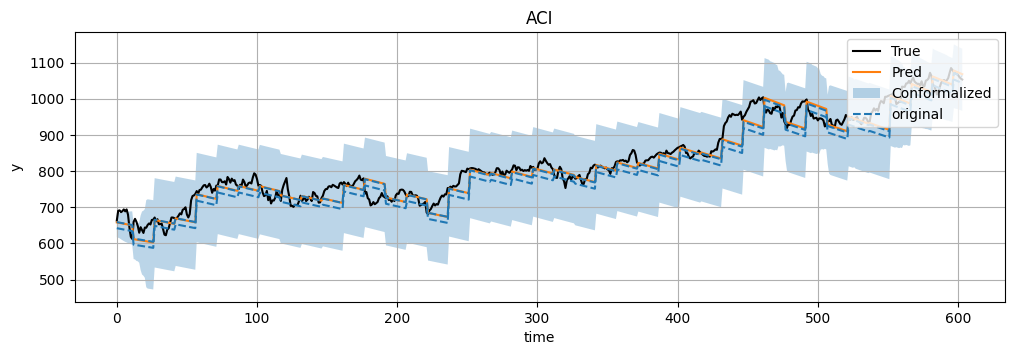

100%|██████████| 604/604 [00:00<00:00, 633.97it/s]


<Figure size 640x480 with 0 Axes>

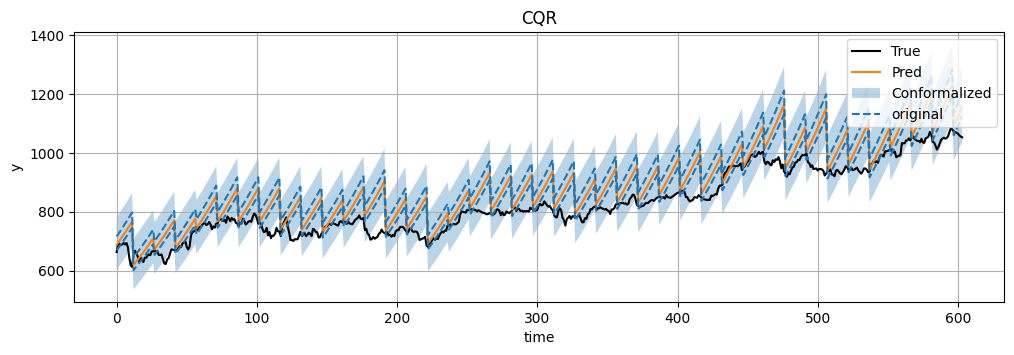

<Figure size 640x480 with 0 Axes>

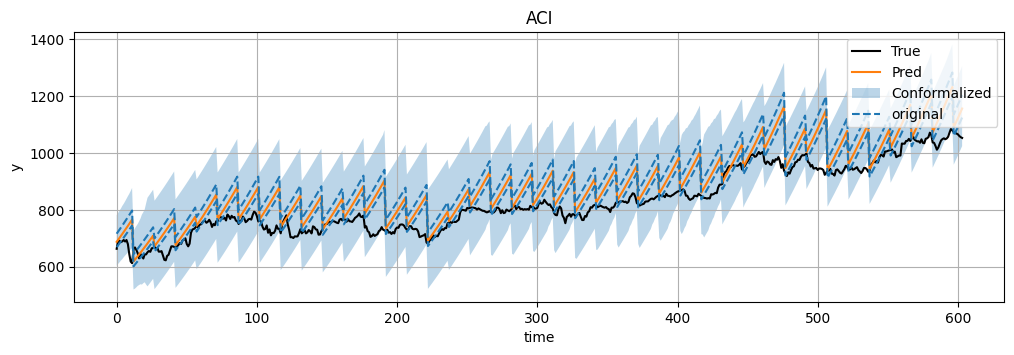

In [14]:
linear_metrics = []
neural_metrics = []


for stepsize in np.arange(3, 18, 3):
    df_linear = pd.DataFrame({"model_name" : [],
                      "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})
    
    df_NN = pd.DataFrame({"model_name" : [],
                      "RMSE" : [], 
                          "PICP" : [], 
                          "PIAW" : [], 
                          "PINAW" : [], 
                          "CWC" : []})
    print("stepsize: ", stepsize)
    
    lin_preds = predict_linear_step(stepsize=stepsize)
    neur_preds = predict_neural_step(stepsize=stepsize)
    
    
    
    df_linear.loc[0] = cqr_predict(lin_preds, df, df_val, df_test, tvt_split)
    df_linear.loc[1] = aci_predict(lin_preds, df, df_val, df_test, tvt_split)
    
    df_NN.loc[0] = cqr_predict(neur_preds, df, df_val, df_test, tvt_split)
    df_NN.loc[1] = aci_predict(neur_preds, df, df_val, df_test, tvt_split)
        
    linear_metrics.append(df_linear)
    neural_metrics.append(df_NN)
    
linear_metrics = np.array(linear_metrics)
neural_metrics = np.array(neural_metrics)

    
    


In [15]:
lin_preds

{'lower': array([[[ 215.93349503],
         [ 218.87487024],
         [ 225.92048993],
         ...,
         [1046.84669907],
         [1045.23304326],
         [1043.62285799]]]),
 'middle': array([[[ 223.01746035],
         [ 226.02098665],
         [ 233.21547988],
         ...,
         [1071.4878127 ],
         [1069.84006044],
         [1068.19585205]]]),
 'upper': array([[[ 231.41286116],
         [ 234.36374424],
         [ 241.4321386 ],
         ...,
         [1065.01195619],
         [1063.39308431],
         [1061.77769419]]])}

In [16]:
linear_metrics

array([[['NN CQR', 14.814122111769425, 0.7682119205298014,
         47.05337905883789, 0.09955858630366447, 0.5347728974558479],
        ['NN ACI', 14.814122111769425, 0.9850993377483444,
         226.9769287109375, 0.48025248341360405, 0.41825288184068654]],

       [['NN CQR', 19.71485163941814, 0.7715231788079471,
         59.34196472167969, 0.12555957158325864, 0.5329328141101014],
        ['NN ACI', 19.71485163941814, 0.9917218543046358,
         295.2015075683594, 0.624606465169395, 0.29165976810844857]],

       [['NN CQR', 23.906791488540286, 0.7764900662251656,
         72.38943481445312, 0.1531662536804476, 0.5358548262392254],
        ['NN ACI', 23.906791488540286, 0.9850993377483444,
         233.47239685058594, 0.4939960155105285, 0.40719314278899815]],

       [['NN CQR', 27.7713324229602, 0.7483443708609272,
         74.63378143310547, 0.15791498758644468, 0.42237691483545964],
        ['NN ACI', 27.7713324229602, 0.9801324503311258,
         308.45611572265625, 0.652651

In [17]:
linear_metrics[:,0,3]

array([47.05337905883789, 59.34196472167969, 72.38943481445312,
       74.63378143310547, 88.6020278930664], dtype=object)

CQR

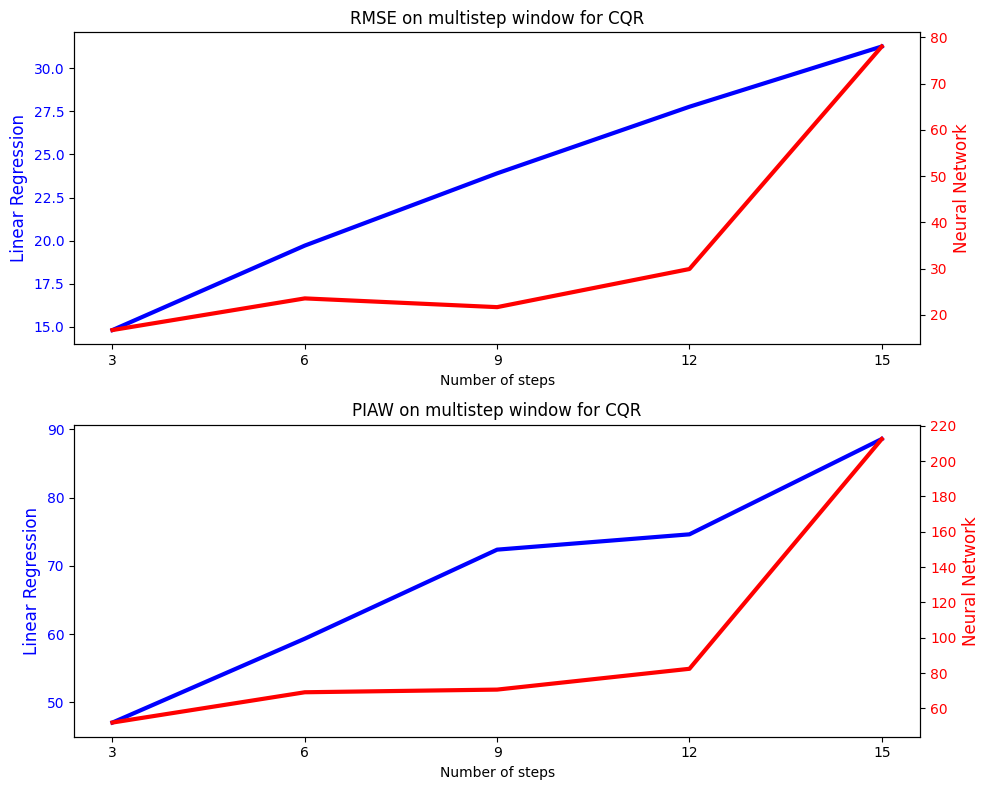

In [45]:


    
lin_rmse = linear_metrics[:,0, 1]  # lin
neur_rmse = neural_metrics[:,0, 1]  # neural
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
# plot the piaw
axs[0].plot(np.arange(3,18,3), lin_rmse.astype(float), label="QLR", lw=3, color="blue")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs[0].set_xlabel("Number of steps")
axs[0].set_xticks(np.arange(3,18,3))
axs[0].set_ylabel(ylabel="Linear Regression", color="blue", fontsize=12)
axs[0].tick_params(axis="y", labelcolor="blue")

axs_1 = axs[0].twinx()
# plot the picp
axs_1.plot(np.arange(3,18,3), neur_rmse.astype(float), label="QLR", color="red", lw=3)
axs_1.set_title("RMSE on multistep window for CQR")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs_1.set_xlabel("Number of steps")
axs_1.set_xticks(np.arange(3,18,3))
axs_1.set_ylabel(ylabel="Neural Network", color="red", fontsize=12)
axs_1.tick_params(axis="y", labelcolor="red")


lin_piaw = linear_metrics[:,0, 3]  # lin
neur_piaw = neural_metrics[:,0, 3]  # neural
# plot the piaw
axs[1].plot(np.arange(3,18,3), lin_piaw.astype(float), label="QLR", lw=3, color="blue")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs[1].set_xlabel("Number of steps")
axs[1].set_xticks(np.arange(3,18,3))
axs[1].set_ylabel(ylabel="Linear Regression", color="blue", fontsize=12)
axs[1].tick_params(axis="y", labelcolor="blue")

axs_1 = axs[1].twinx()


# plot the picp
axs_1.plot(np.arange(3,18,3), neur_piaw.astype(float), label="QLR",  color="red", lw=3)
axs_1.set_title("PIAW on multistep window for CQR")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs_1.set_xlabel("Number of steps")
axs_1.set_xticks(np.arange(3,18,3))
axs_1.set_ylabel(ylabel="Neural Network", color="red", fontsize=12)
axs_1.tick_params(axis="y", labelcolor="red")

fig.tight_layout()
plt.show()

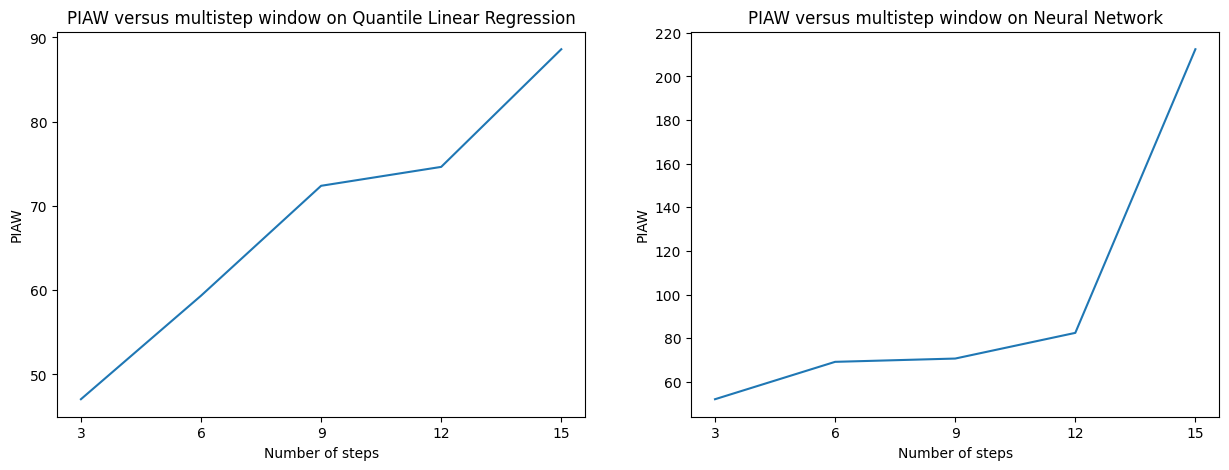

In [33]:


    
lin_piaw = linear_metrics[:,0, 3]  # lin
neur_piaw = neural_metrics[:,0, 3]  # neural
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# plot the piaw
axs[0].plot(np.arange(3,18,3), lin_piaw.astype(float), label="QLR")
axs[0].set_title("PIAW versus multistep window on Quantile Linear Regression")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs[0].set_xlabel("Number of steps")
axs[0].set_ylabel("PIAW")
axs[0].set_xticks(np.arange(3,18,3))


# plot the picp
axs[1].plot(np.arange(3,18,3), neur_piaw.astype(float), label="QLR")
axs[1].set_title("PIAW versus multistep window on Neural Network")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs[1].set_xlabel("Number of steps")
axs[1].set_ylabel("PIAW")
axs[1].set_xticks(np.arange(3,18,3))


plt.show()

aci

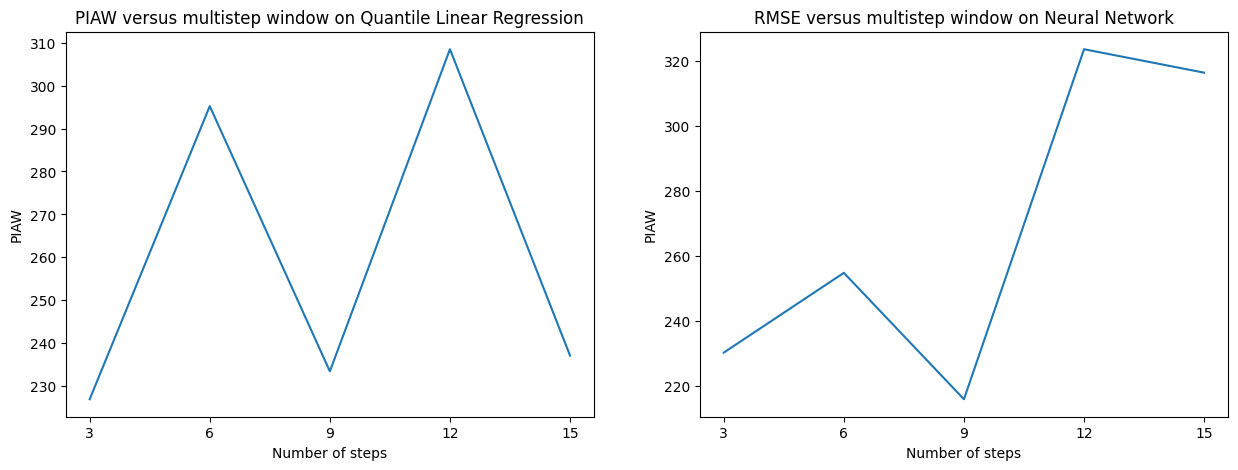

In [34]:


    
lin_piaw = linear_metrics[:,1, 3]  # lin
neur_piaw = neural_metrics[:,1, 3]  # neural
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# plot the piaw
axs[0].plot(np.arange(3,18,3), lin_piaw.astype(float), label="QLR")
axs[0].set_title("PIAW versus multistep window on Quantile Linear Regression")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs[0].set_xlabel("Number of steps")
axs[0].set_ylabel("PIAW")
axs[0].set_xticks(np.arange(3,18,3))


# plot the picp
axs[1].plot(np.arange(3,18,3), neur_piaw.astype(float), label="QLR")
axs[1].set_title("PIAW versus multistep window on Neural Network")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs[1].set_xlabel("Number of steps")
axs[1].set_ylabel("PIAW")
axs[1].set_xticks(np.arange(3,18,3))


plt.show()

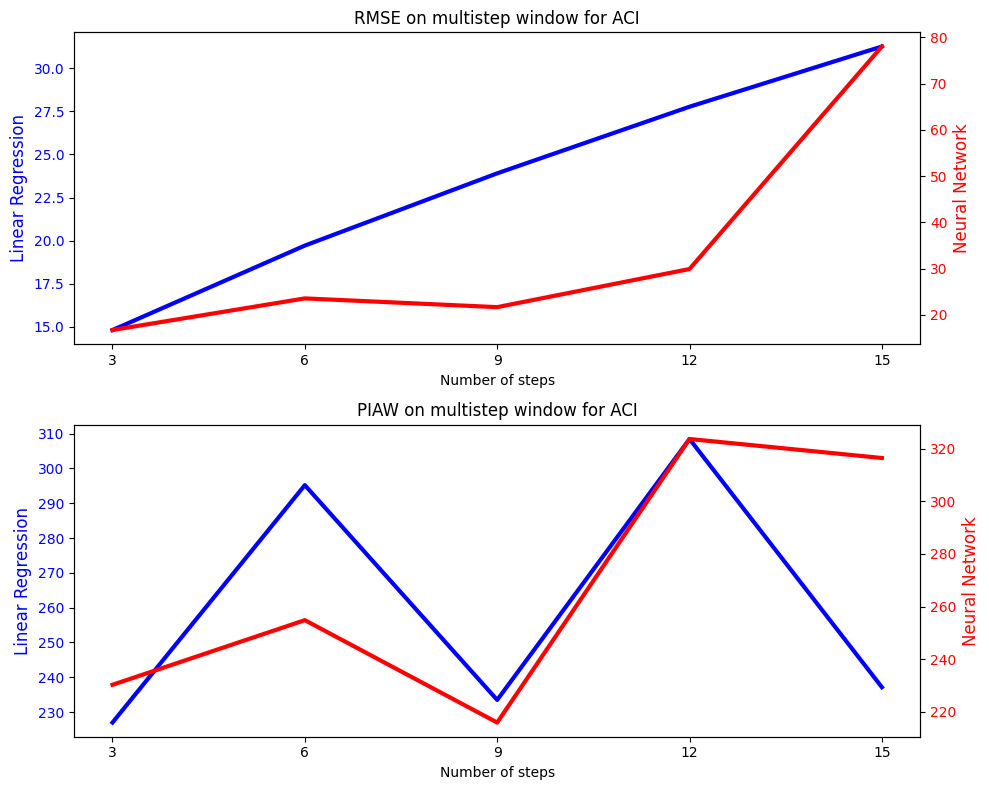

In [46]:

    
lin_rmse = linear_metrics[:,1, 1]  # lin
neur_rmse = neural_metrics[:, 1, 1]  # neural
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
# plot the piaw
axs[0].plot(np.arange(3,18,3), lin_rmse.astype(float), label="QLR", lw=3, color="blue")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs[0].set_xlabel("Number of steps")
axs[0].set_xticks(np.arange(3,18,3))
axs[0].set_ylabel(ylabel="Linear Regression", color="blue", fontsize=12)
axs[0].tick_params(axis="y", labelcolor="blue")

axs_1 = axs[0].twinx()
# plot the picp
axs_1.plot(np.arange(3,18,3), neur_rmse.astype(float), label="QLR", color="red", lw=3)
axs_1.set_title("RMSE on multistep window for ACI")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs_1.set_xlabel("Number of steps")
axs_1.set_xticks(np.arange(3,18,3))
axs_1.set_ylabel(ylabel="Neural Network", color="red", fontsize=12)
axs_1.tick_params(axis="y", labelcolor="red")


lin_piaw = linear_metrics[:,1, 3]  # lin
neur_piaw = neural_metrics[:,1, 3]  # neural
# plot the piaw
axs[1].plot(np.arange(3,18,3), lin_piaw.astype(float), label="QLR", lw=3, color="blue")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs[1].set_xlabel("Number of steps")
axs[1].set_xticks(np.arange(3,18,3))
axs[1].set_ylabel(ylabel="Linear Regression", color="blue", fontsize=12)
axs[1].tick_params(axis="y", labelcolor="blue")

axs_1 = axs[1].twinx()


# plot the picp
axs_1.plot(np.arange(3,18,3), neur_piaw.astype(float), label="QLR",  color="red", lw=3)
axs_1.set_title("PIAW on multistep window for ACI")
# plt.scatter(gamma_nn, scores_nn[np.where(param_range == gamma_nn), 2].astype(float), color="red")
axs_1.set_xlabel("Number of steps")
axs_1.set_xticks(np.arange(3,18,3))
axs_1.set_ylabel(ylabel="Neural Network", color="red", fontsize=12)
axs_1.tick_params(axis="y", labelcolor="red")

fig.tight_layout()
plt.show()